In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.16.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/harsh/mynlpenv/lib/python3.11/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: tensorflow-macos


In [2]:
# Imports
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [3]:
data = pd.read_csv('MicrosoftStock.csv')
print(data.head())
print(data.info())
print(data.describe())

    index        date   open   high    low  close    volume  Name
0  390198  2013-02-08  27.35  27.71  27.31  27.55  33318306  MSFT
1  390199  2013-02-11  27.65  27.92  27.50  27.86  32247549  MSFT
2  390200  2013-02-12  27.88  28.00  27.75  27.88  35990829  MSFT
3  390201  2013-02-13  27.93  28.11  27.88  28.03  41715530  MSFT
4  390202  2013-02-14  27.92  28.06  27.87  28.04  32663174  MSFT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB
None
               index         open         high          low 

Text(0, 0.5, 'Price (USD)')

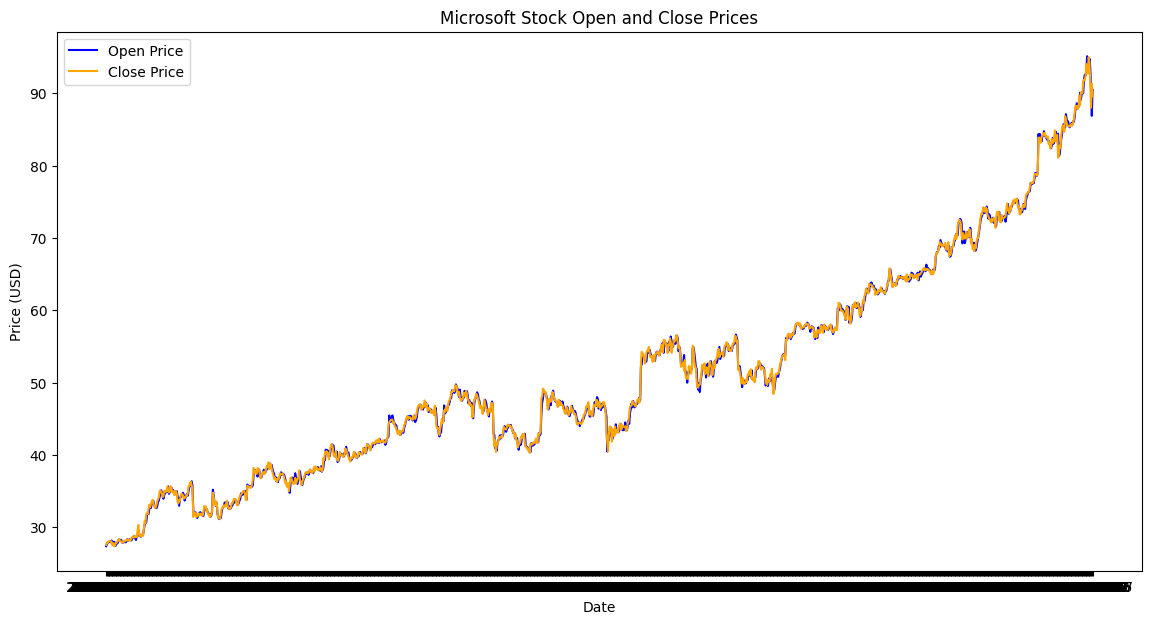

In [4]:
# Initial data visualization 
# Plot 1 : Open and Close prices
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['open'], label='Open Price', color='blue')
plt.plot(data['date'], data['close'], label='Close Price', color='orange')
plt.title('Microsoft Stock Open and Close Prices')
plt.xlabel('Date')
plt.legend()
plt.ylabel('Price (USD)')

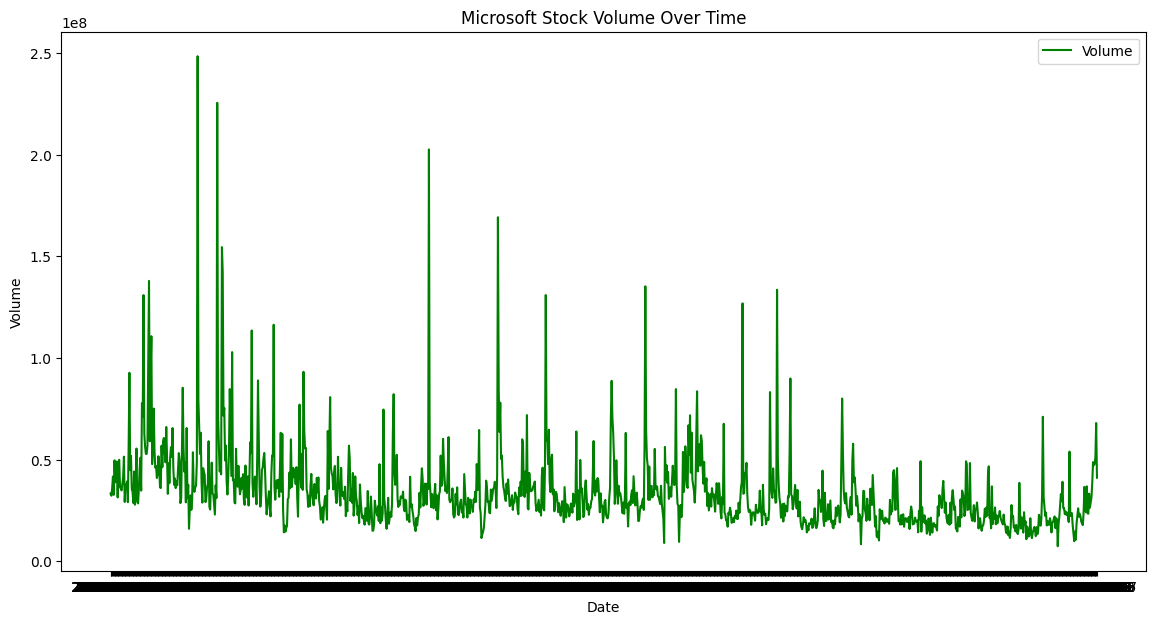

In [5]:
# Plot 2 : Volume over time
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['volume'], label='Volume', color='green')
plt.title('Microsoft Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


In [6]:
# Drop unnecessary columns (non-numeric or redundant)
numeric_data = data.select_dtypes(include=["int64", "float64"])

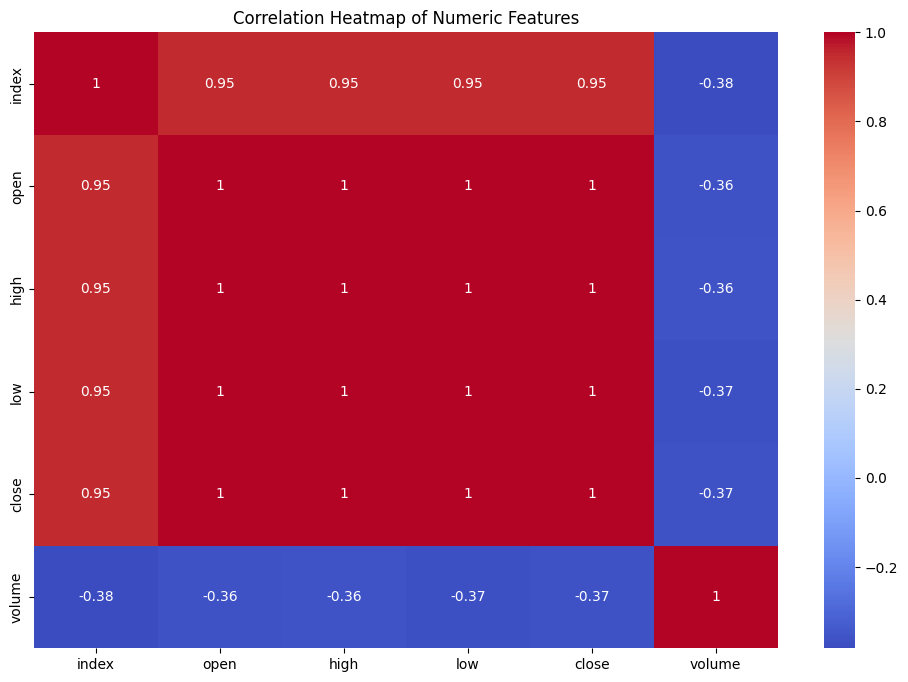

In [7]:
# Check for correlation between numeric features
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


In [8]:
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])

In [9]:
prediction = data.loc[
    (data['date'] > datetime(2013,1,1)) & (data['date'] < datetime(2018,1,1))
]

In [10]:
# Prepare the LSTM Model (Sequential)
dataset = data['close'].values 
train_size = int(np.ceil(len(dataset) * 0.95))

In [11]:
print(dataset.reshape(-1, 1).shape)

(1259, 1)


In [12]:
# Data Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset.reshape(-1, 1))
training_data = scaled_data[:train_size]

In [13]:
X_train, y_train = [], []

# Create a sliding window of 60 days for the stock
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
print(X_train.shape)

(1137, 60)


In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # Making it 3D for Tensorflow
print(X_train.shape)

(1137, 60, 1)


# Building the Model

In [16]:
model = keras.models.Sequential()

In [17]:
# First layer - learns the patterns from past 60 days of stock prices 
model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))

2025-07-03 15:39:43.815965: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-07-03 15:39:43.815987: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-03 15:39:43.815990: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-07-03 15:39:43.816005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-03 15:39:43.816015: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/harsh/mynlpenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models

In [18]:
# Second layer - This layer keeps the important features from the first layer
model.add(keras.layers.LSTM(units=64, return_sequences=False))

In [19]:
# Third Layer (Dense Layer) - This layer helps the model adjust and learn complex patterns in the data
model.add(keras.layers.Dense(units=128, activation='relu'))

In [20]:
# Fourth Layer (Dropout Layer) , to prevent overfitting - it prevents the model from being too sensitive to the training data and helps it perform better on new data
model.add(keras.layers.Dropout(0.5))

In [21]:
# Final output layer - This layer predicts the stock prices 
model.add(keras.layers.Dense(units=1)) 

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.RootMeanSquaredError()])

# Train the model

In [24]:
training = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20


2025-07-03 15:39:44.520856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.3335 - root_mean_squared_error: 0.4634
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1219 - root_mean_squared_error: 0.1614
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1037 - root_mean_squared_error: 0.1343
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1024 - root_mean_squared_error: 0.1350
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1019 - root_mean_squared_error: 0.1339
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0971 - root_mean_squared_error: 0.1371
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0875 - root_mean_squared_error: 0.1176
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0937 - root_mean_squared_error: 0.1273
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0895 - root_mean_squared_error: 0.1210
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0867 - root_mean_squared_error: 0.1161
Epoch 11/2

In [25]:
# Prep test data
test_data = scaled_data[train_size - 60:]
X_test, y_test = [], dataset[train_size:]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [26]:
# Make predictions 
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


/var/folders/lk/9zql6l_s4fn6rj08c1xp00k00000gn/T/ipykernel_94455/3723204049.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


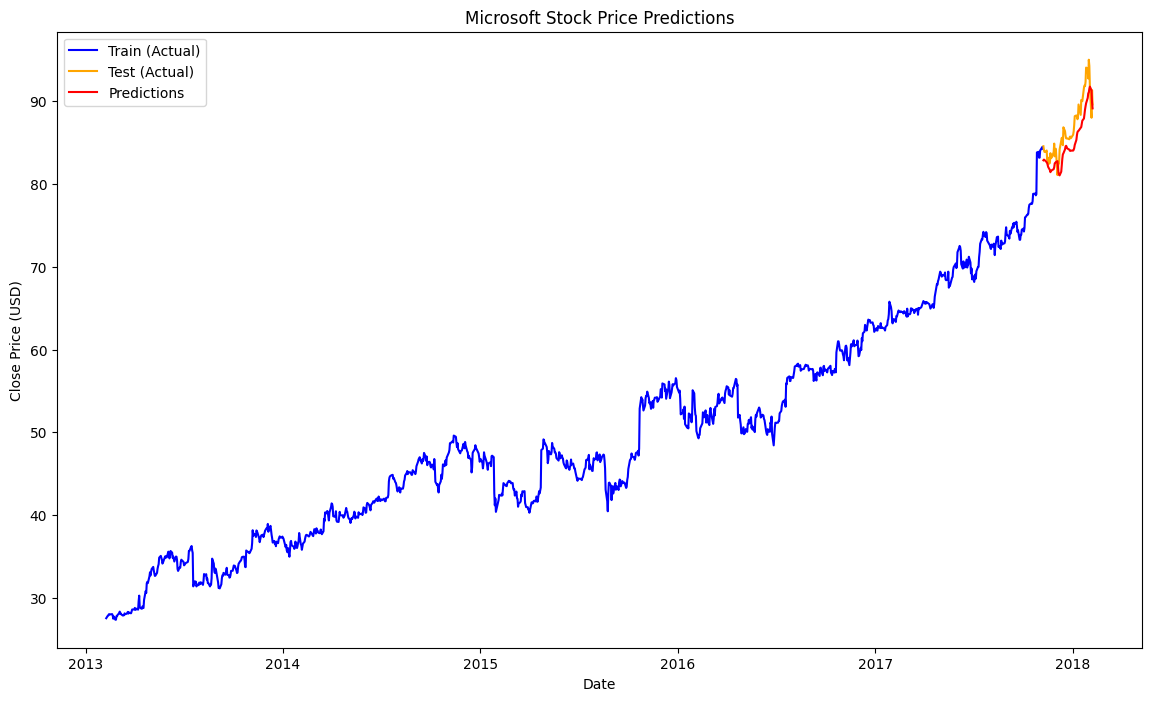

In [27]:
# Plotting data
train = data[:train_size]
test = data[train_size:]
test['Predictions'] = predictions
plt.figure(figsize=(14, 8))
plt.plot(train['date'], train['close'], label='Train (Actual)', color='blue')
plt.plot(test['date'], test['close'], label='Test (Actual)', color='orange')
plt.plot(test['date'], test['Predictions'], label='Predictions', color='red')
plt.title('Microsoft Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Inverse transform to get actual price scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(predictions.reshape(-1, 1))

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.4f}")


Root Mean Squared Error (RMSE): 33.46
Mean Absolute Error (MAE): 29.87
R² Score: 0.5924


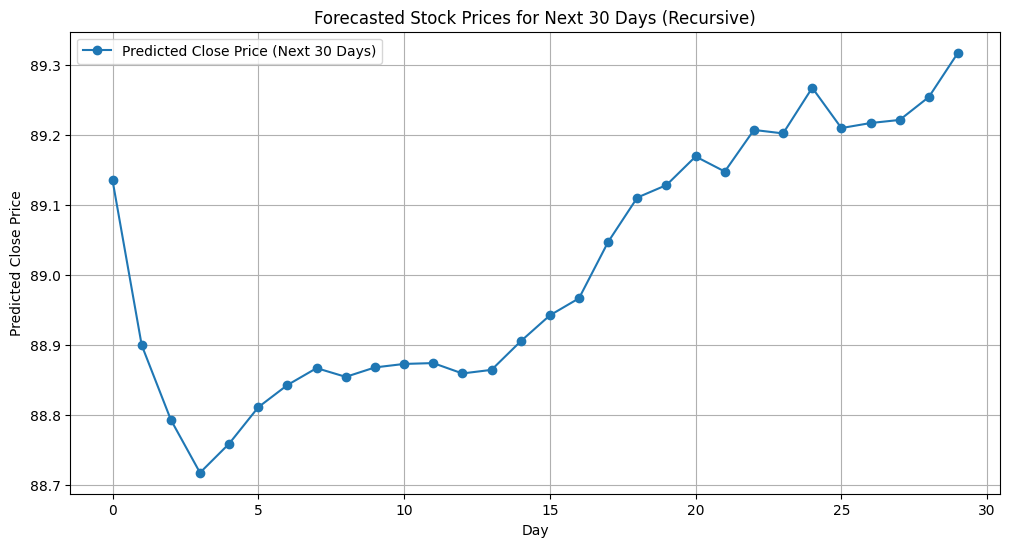

In [ ]:
import copy

# Start with last 60 days from test data
input_seq = list(X_test[-1])  # shape: (60, number of features)
predicted_30 = []

for i in range(30):
    # Convert to correct shape for model input
    current_input = np.array(input_seq[-60:]).reshape(1, 60, X_test.shape[2])
    
    # Predict next day's scaled price
    next_pred_scaled = model.predict(current_input, verbose=0)
    
    # Create dummy feature vector for next day using prediction and noise
    next_features = copy.deepcopy(input_seq[-1])  # start with last day's feature vector
    next_features[0] = next_pred_scaled[0][0]  # replace Close_Price (assumed index 3)
    
    # Add small Gaussian noise to simulate realistic variation
    noise = np.random.normal(0.14, 0.01, size=len(next_features))  # 1% noise with positive bias (growth)
    next_features_noisy = next_features + noise
    
    # Append new noisy input for future forecasting
    input_seq.append(next_features_noisy)
    
    # Save the predicted close price
    predicted_30.append(next_pred_scaled[0][0])

# Inverse scale predictions
predicted_30_actual = scaler.inverse_transform(np.array(predicted_30).reshape(-1, 1))

# Plot the predictions
plt.figure(figsize=(12,6))
plt.plot(predicted_30_actual, label='Predicted Close Price (Next 30 Days)', marker='o')
plt.title('Forecasted Stock Prices for Next 30 Days (Recursive)')
plt.xlabel('Day')
plt.ylabel('Predicted Close Price')
plt.grid(True)
plt.legend()
plt.show()
